In [474]:
# import

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import torchvision

from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from path import Path
import os
import json

#os.environ["CUDA_VISIBLE_DEVICES"] ="2, 3"

In [478]:
import altair as alt
import pandas as pd

In [479]:
import random

In [580]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [481]:
device

'cuda:3'

### MODEL (AE)

In [581]:
class Encoder (nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, latent_dims)
        self.relu = nn.ReLU()
        
        
    def forward(self, x): #x : torch.Size([64, 2, 400])
        x = torch.flatten(x, start_dim=1) # x.shape : torch.Size([64, 800])
        x = self.relu(self.fc1(x)) # x.shape : torch.Size([64, 512]) 
        x = self.fc2(x)
        return x #shape = torch.Size([64, 5])

In [582]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dims, 512)
        self.fc2 = nn.Linear(512, 800)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = self.sigmoid(self.fc2(z)) #z.shape : torch.Size([64, 800])
        z = torch.reshape(z, (-1, 400, 2)) #뒤에서도 사용할려면 64대신 일반화 해야함.
        return z

In [583]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## DATA

In [586]:
class DRPointData(Dataset):
    def __init__(self, root_dir, valid=False):
        self.root_dir = root_dir
        self.valid = valid
        self.files = [_ for _ in os.listdir(root_dir) if _.endswith('.json')]
        self.files = self.files[:4000]
        
    def __len__(self):
        return len(self.files)
    
    def __preproc__(self, file):
        with open(file, encoding="UTF-8") as f:
            
            np_points = np.array(json.load(f, strict=False))
            nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto').fit(np_points)
            matrix = torch.from_numpy(nbrs.kneighbors_graph(np_points).toarray())
            points = torch.from_numpy(np_points)
            max_val = torch.max(points, -2).values.view(1, -1)
            min_val = torch.min(points, -2).values.view(1, -1)
            diff = max_val - min_val 
            points = (points - min_val) / diff
        return {'points': points, #[400, 2]
               'KNN':matrix}
        
    def __getitem__(self, idx):
        json_file = os.path.join(self.root_dir, self.files[idx])
        item = self.__preproc__(json_file)
        return item
    
    def __filename__(self, idx):
        return self.files[idx]
        

In [587]:
path = Path("data_0610")
train_dr = DRPointData(path)
len(train_dr)

4000

In [588]:
dataloader = DataLoader(dataset=train_dr, batch_size=32, drop_last=True)

In [589]:
with open('label.json') as f:
    labels = np.array(json.load(f))

In [ ]:
labels

torch.Size([400, 2])


[296, 2009, 1173, 1701]

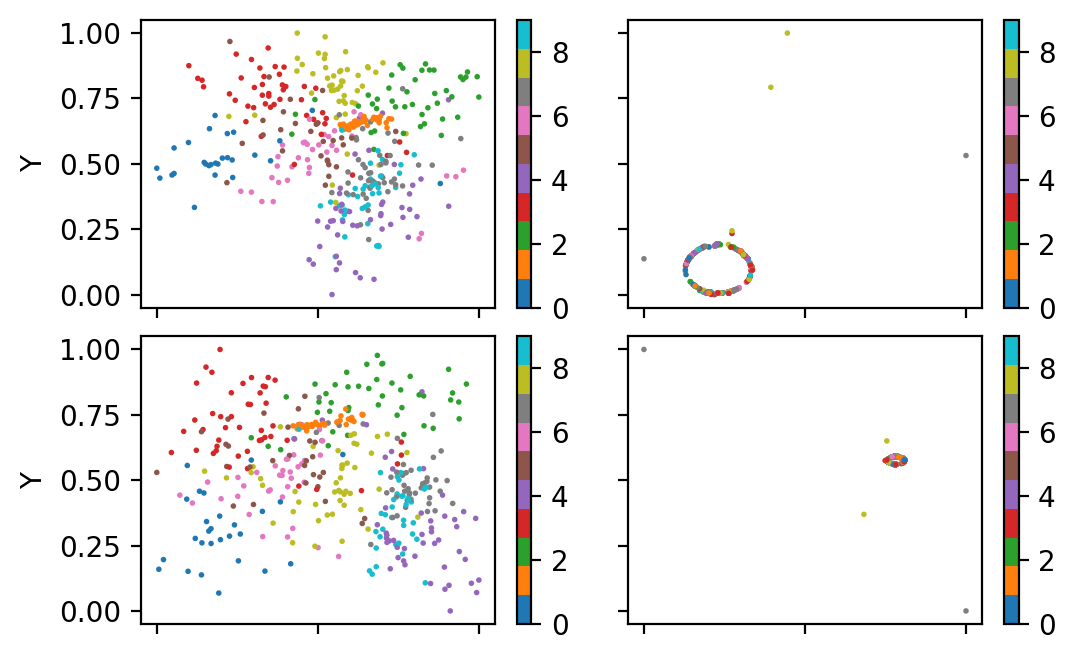

In [399]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,   gridspec_kw={'hspace': 0.1, 'wspace': 0.1})


idx = []
for i in range(4):
    idx.append(random.randint(0, len(train_dr)))

df0 = pd.DataFrame(points_data[idx[0]].numpy(), columns=['X', 'Y'])
df1 = pd.DataFrame(points_data[idx[1]].numpy(), columns=['X', 'Y'])
df2 = pd.DataFrame(points_data[idx[2]].numpy(), columns=['X', 'Y'])
df3 = pd.DataFrame(points_data[idx[3]].numpy(), columns=['X', 'Y'])

print(points_data[idx[0]].shape) #torch.Size([400, 2])

df0.plot.scatter(x='X', y='Y', ax=axes[0,0], s=1, c=labels, cmap='tab10')
df1.plot.scatter(x='X', y='Y', ax=axes[0,1], s=1, c=labels, cmap='tab10')
df2.plot.scatter(x='X', y='Y', ax=axes[1,0], s=1, c=labels, cmap='tab10')
df3.plot.scatter(x='X', y='Y', ax=axes[1,1], s=1, c=labels, cmap='tab10')

idx


## AutoEncoder (train)

In [599]:
def train(model, dataloader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        print(epoch)
        autoencoder.train()
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            #inputs, kNN = data['points'].to(device).float(), data['KNN'].to(device).int()
            inputs = data['points'].to(device).float()
            optimizer.zero_grad()
            x_hat = autoencoder(inputs.transpose(1, 2))
            loss = ((inputs - x_hat)**2).sum()
            loss.backward()
            optimizer.step()
    return model

In [600]:
latent_dims = 10
autoencoder = Autoencoder(latent_dims).to(device)

In [ ]:
autoencoder = train(autoencoder, dataloader)

In [608]:
def plot_latent(model, dataloader, num_batches=50):
    for i, x in enumerate(dataloader):
        x = x['points']
        z = model.encoder(x.to(device).float())
        z = z.to('cpu').detach().numpy()
        # 64개씩 끊어서
        plt.scatter(z[:, 0], z[:, 1], cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

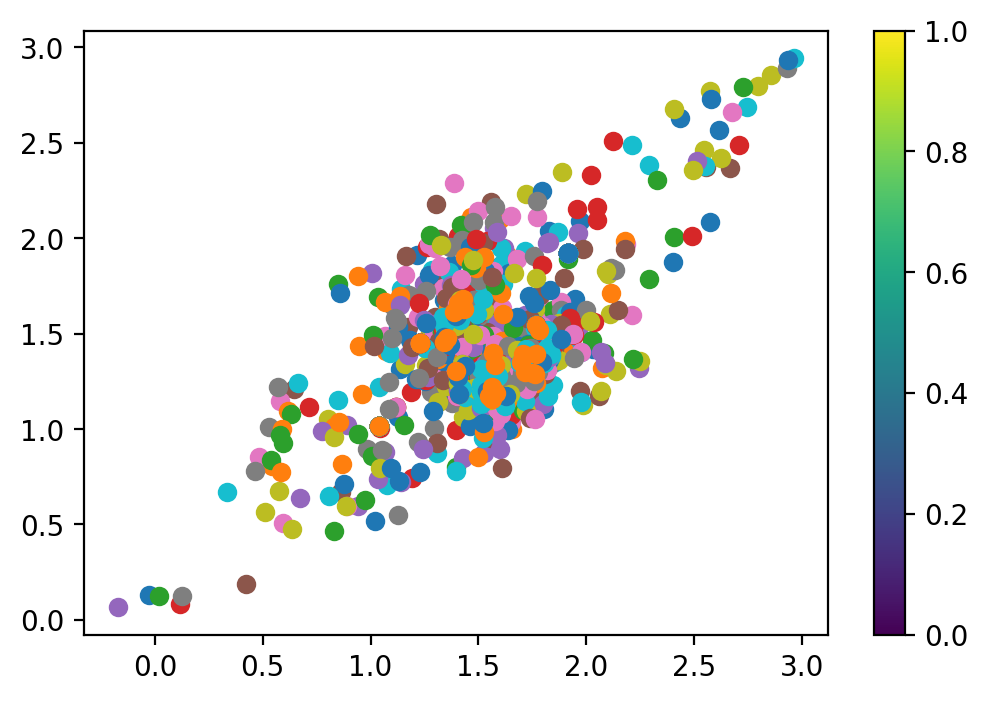

In [609]:
plot_latent(autoencoder, dataloader)

In [450]:
def plot_reconstructed(autoencoder, r0=(-0.6, 0.0), r1=(0, 0.6), n=4):
    fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True,   gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)): #i, j for index
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            df = pd.DataFrame(x_hat[0].to('cpu').detach().numpy(), columns=['X', 'Y'])
            df.plot.scatter(x='X', y='Y', ax=axes[i,j], s=0.5, c=labels, cmap='tab10')
 

In [ ]:
plot_reconstructed(autoencoder, r0=(0, 1.7), r1=(0, 2.0), n=5)

## Variational Autoencoder (VAE)

In [420]:
class VariationalEncoder (nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, latent_dims)
        self.fc3 = nn.Linear(512, latent_dims)
        
        self.relu = nn.ReLU()
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
        
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        mu =  self.fc2(x)
        sigma = torch.exp(self.fc3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [421]:
class VAE(nn.Module):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

to train the vae, only need to add the auxillary loss in training algorithm

In [441]:
def train_vae(model, dataloader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in epochs:
        print(epoch)
        vae.train()
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, kNN = data['points'].to(device).float(), data['KNN'].to(device).int()
            optimizer.zero_grad()
            x_hat = vae(inputs.transpose(1, 2))
            loss = ((inputs - x_hat)**2).sum()
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            loss.backward()
            optimizer.step()


In [442]:
latent_dims = 10
vae = VAE(latent_dims).to(device)

In [443]:
vae = train(vae, dataloader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
plot_latent(vae, dataloader)

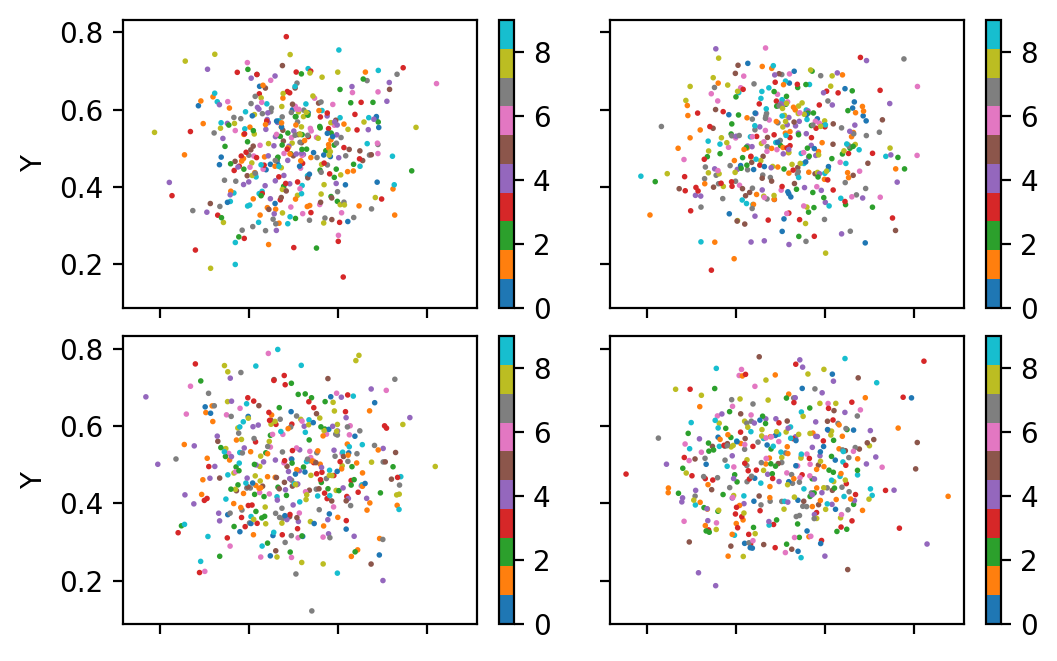

In [340]:
plot_reconstructed(vae, r0=(-2, 2),r1=(-2, 2), n=2)